In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from apdist.torch import TorchAmplitudePhaseDistance as torch_apdist 
import torch 
from apdist.torch import plot_warping as plot_warping_torch
from apdist.distances import AmplitudePhaseDistance as numpy_apdist 
from apdist.utils import plot_warping 
from apdist.geometry import SquareRootSlopeFramework as SRSF
import matplotlib.gridspec as gridspec


### Load the data
Load the SAS data from the notebooks data folder

In [3]:
q_grid = np.load('./data/01/q_grid.npy')
q_grid_scaled = np.load('./data/01/q_grid_scaled.npy')
I_good = np.load('./data/01/I_sobol.npy')
I_bad = np.load('./data/01/I_baseline.npy')
target_I = np.load('./data/01/targetI.npy')

### Visualize the SAS data
We are comparing two SAS curves to a reference and find out which one is closer to the reference.

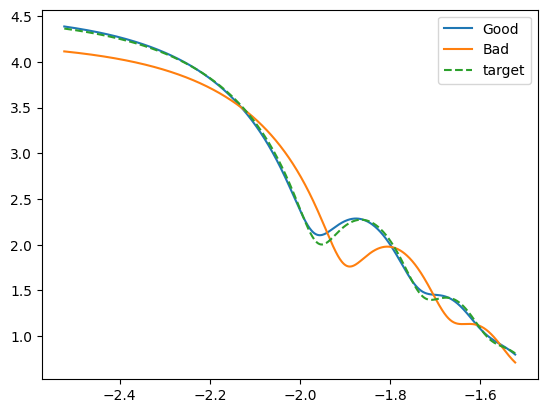

In [4]:
fig, ax = plt.subplots()

ax.plot(q_grid, I_good, label = 'Good')
ax.plot(q_grid, I_bad, label = 'Bad')

ax.plot(q_grid, target_I, ls = '--', label = 'target')
ax.legend()
plt.show()

## Case 1

Amplitude : 0.2201, Phase : 0.1482, Total : 0.3682


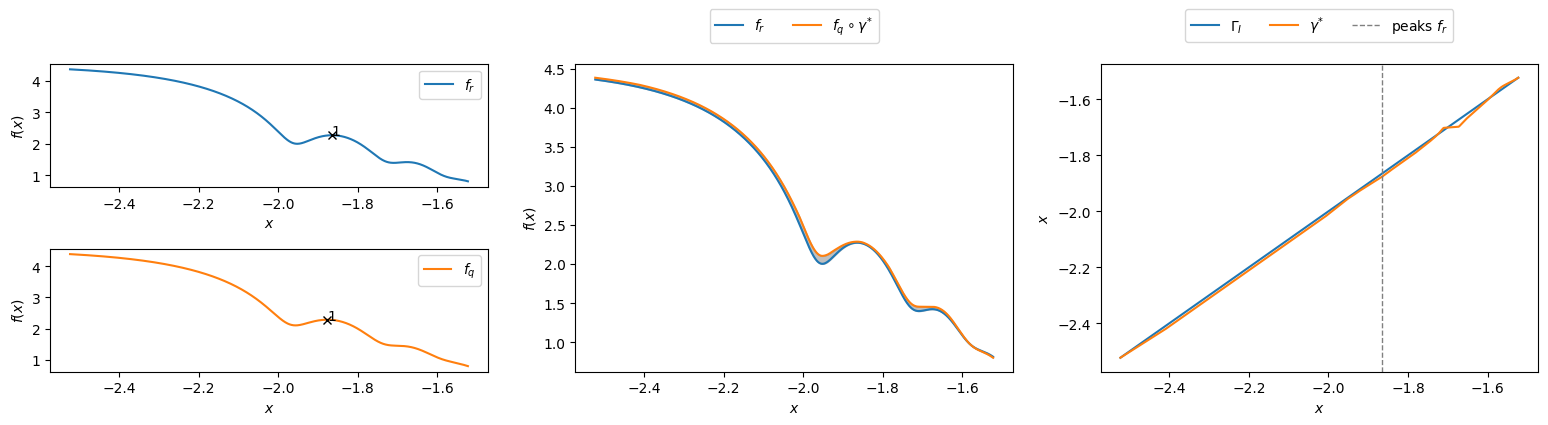

In [5]:
optim_kwargs = {"optim":"DP", "grid_dim":10}
a, p = numpy_apdist(q_grid_scaled, target_I, I_good, **optim_kwargs)
print("Amplitude : %2.4f, Phase : %2.4f, Total : %2.4f"%(a, p, a+p))

srsf = SRSF(q_grid_scaled)
q_ref = srsf.to_srsf(target_I)
q_good = srsf.to_srsf(I_good)
gamma_good = srsf.get_gamma(q_ref, q_good, **optim_kwargs)
f_query_gamma = srsf.warp_f_gamma(I_good, gamma_good)
plot_warping(q_grid, target_I, I_good, f_query_gamma, gamma_good)
plt.show()

## Case 2

Amplitude : 0.1860, Phase : 0.1351, Total : 0.3211


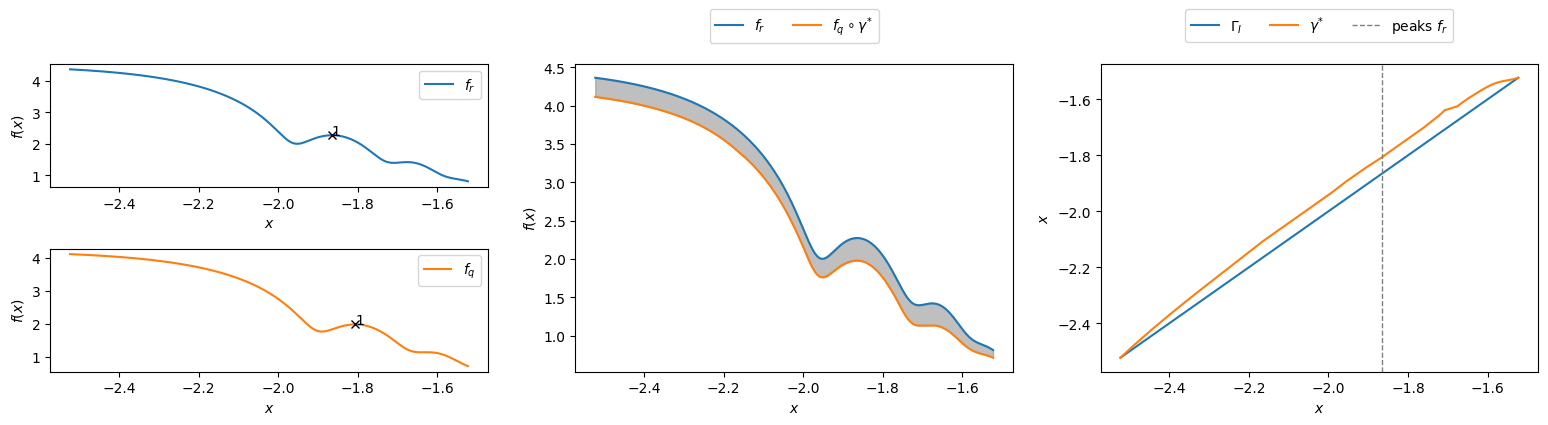

In [6]:
a, p = numpy_apdist(q_grid_scaled, target_I, I_bad, **optim_kwargs)
print("Amplitude : %2.4f, Phase : %2.4f, Total : %2.4f"%(a, p, a+p))

q_bad = srsf.to_srsf(I_bad)
gamma_bad = srsf.get_gamma(q_ref, q_bad, **optim_kwargs)
f_query_gamma = srsf.warp_f_gamma(I_bad, gamma_bad)
plot_warping(q_grid, target_I, I_bad, f_query_gamma, gamma_bad)
plt.show()

As can be seen, although the aligned functions and the distance measured by shaded regions show that second case has much bigger amplitude distance, the actual distance values doesn't reflect that. This is because, the amplitude distance is between the SRSFs of the functions and not the functions themselves. The SRSFs also measure the shape of the aligned functions and features (using a derivative) and are slightly different in the two cases. But the biggest cause for this mis-representation in the distance functions is the alignments resulting from the warping functions itself. 

The small flat and sharp changes we see in the warping functions are a result of the discrete nature of dynamic programming approach that result in large change in the SRSFs that are derivative based. So although, visually we can infer that case 2 should have much more amplitude distance, the actual distance values are not reflective of that. We can use the SRSF transforms of the original functions to infer the reasons for this abnormal amplitude distance values.

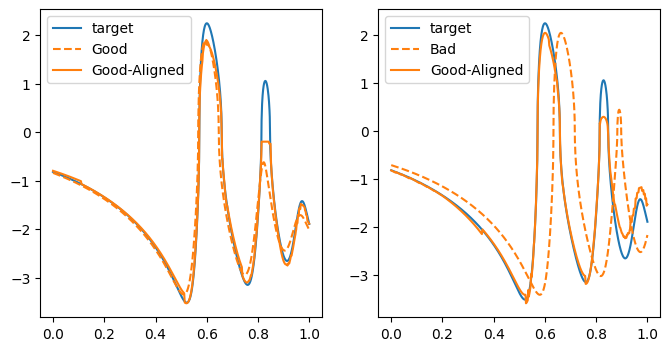

In [7]:
fig, axs = plt.subplots(1,2, figsize=(4*2,4))
for ax in axs:
    ax.plot(q_grid_scaled, q_ref, label = 'target')
axs[0].plot(q_grid_scaled, 
            q_good, 
            label = 'Good', 
            ls="--", 
            color="tab:orange",
        )
axs[0].plot(q_grid_scaled, 
            srsf.warp_q_gamma(q_good, gamma_good), 
            label = 'Good-Aligned', 
            color="tab:orange"
        )
axs[0].legend()

axs[1].plot(q_grid_scaled, 
            q_bad, 
            label = 'Bad', 
            ls="--", 
            color="tab:orange"
        )
axs[1].plot(q_grid_scaled, 
            srsf.warp_q_gamma(q_bad, gamma_bad), 
            label = 'Good-Aligned', 
            color="tab:orange"
        )

axs[1].legend()
plt.show()

Using the figures below, we make severla observations:
1. We can see in the figure below that on the left panel, we essentially ended up with a peak that is flat and which is not what we would've wanted. 
2. Similarily, for the plot on the right, we see that the warping "added" a peak which is also not what we would've wanted--but this will result in a penalty in the phase component of the distance so this not as big of an issue. 

We can also see that the gradients of the Warping function which are used in the distance computation have sharp changes. 

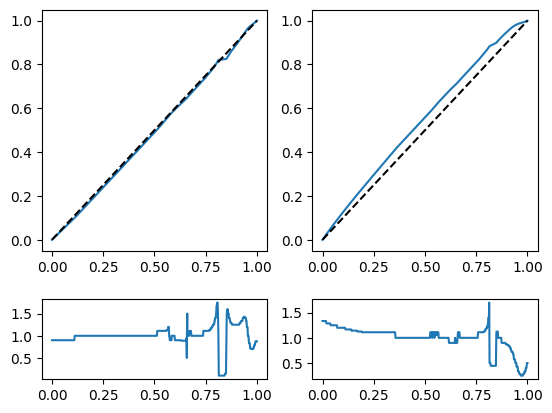

In [8]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], hspace=0.3)

# Plot gamma and its derivative for good
ax_top = fig.add_subplot(gs[0, 0])     
ax_bottom = fig.add_subplot(gs[1, 0])  
ax_top.plot(q_grid_scaled, gamma_good)
ax_top.plot(q_grid_scaled, q_grid_scaled, ls="--", color="k")
ax_bottom.plot(q_grid_scaled, np.gradient(gamma_good, q_grid_scaled))

# Bad
ax_top = fig.add_subplot(gs[0, 1])    
ax_bottom = fig.add_subplot(gs[1, 1]) 
ax_top.plot(q_grid_scaled, gamma_bad)
ax_top.plot(q_grid_scaled, q_grid_scaled, ls="--", color="k")
ax_bottom.plot(q_grid_scaled, np.gradient(gamma_bad, q_grid_scaled))

plt.show()

This is where the torch version of the distance function comes in. Since it uses a continuous optimization approach, it is able to capture the subtle features in the functions and provide a more accurate distance measure. 

## Case 1

Amplitude : 0.2575, Phase : 0.1143, Total : 0.371828


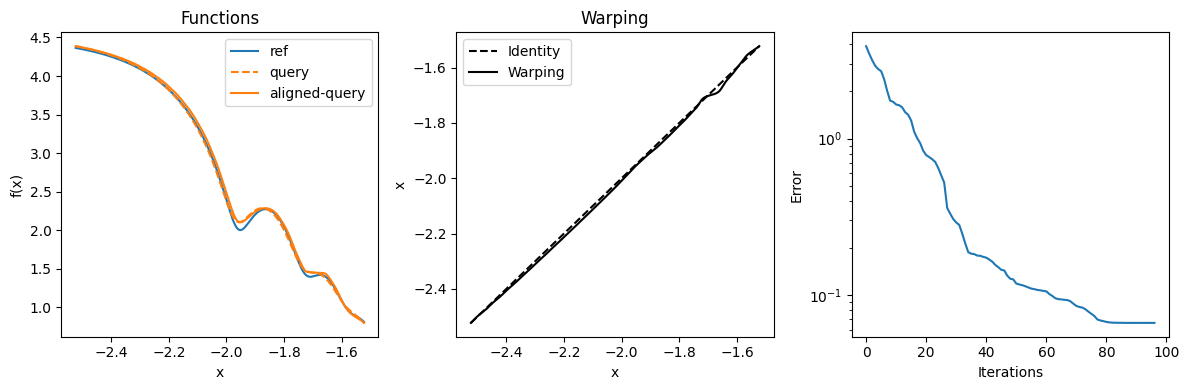

In [9]:
optim_kwargs = {"n_iters":100, 
                "n_basis":20, 
                "n_layers":20,
                "n_restarts":128,
                "domain_type":"linear",
                "basis_type":"palais",
                "lr":1e-1,
                "n_domain":q_grid.shape[0],
                "eps":1e-2,
                "verbose" : True
            }

amplitude, phase, output_good = torch_apdist(torch.from_numpy(q_grid_scaled), # all the inputs should be torch.Tensor
                                        torch.from_numpy(target_I), 
                                        torch.from_numpy(I_good), 
                                        **optim_kwargs
                                    )
print("Amplitude : %2.4f, Phase : %2.4f, Total : %2.4f"%(amplitude.item(), phase.item(), amplitude.item()+phase.item()))
plot_warping_torch(q_grid, target_I, I_good, output_good)


## Case 2

Amplitude : 0.2041, Phase : 0.1471, Total : 0.351228


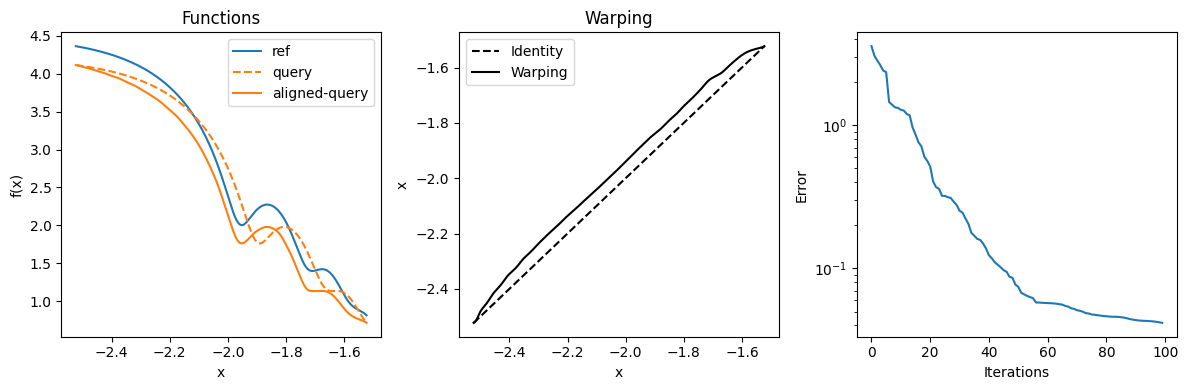

In [10]:
amplitude, phase, output_bad = torch_apdist(torch.from_numpy(q_grid_scaled), # all the inputs should be torch.Tensor
                                        torch.from_numpy(target_I), 
                                        torch.from_numpy(I_bad), 
                                        **optim_kwargs
                                    )
print("Amplitude : %2.4f, Phase : %2.4f, Total : %2.4f"%(amplitude.item(), phase.item(), amplitude.item()+phase.item()))
plot_warping_torch(q_grid, target_I, I_bad, output_bad)

We can now inspect the aligned SRSF's from the torch warping to compute the amplitude and phase distance. 

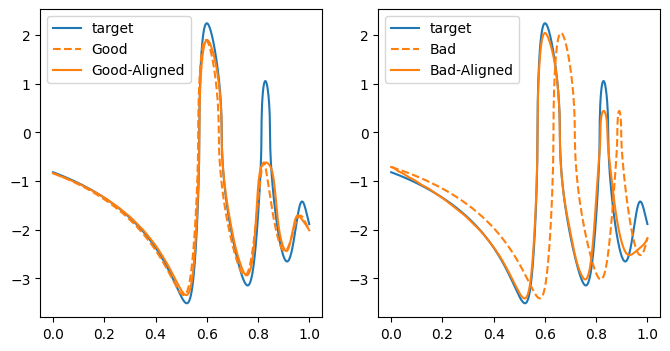

In [11]:
from funcshape.functions import Function, SRSF 

t = torch.from_numpy(q_grid_scaled)
q_ref = SRSF(Function(t, torch.from_numpy(target_I).reshape(-1,1)))
q_good = SRSF(Function(t, torch.from_numpy(I_good).reshape(-1,1)))
q_bad = SRSF(Function(t, torch.from_numpy(I_bad).reshape(-1,1)))

fig, axs = plt.subplots(1,2, figsize=(4*2,4))
for ax in axs:
    ax.plot(q_grid_scaled, 
            q_ref.qx, 
            label = 'target'
        )
axs[0].plot(q_grid_scaled, 
            q_good.qx, 
            label = 'Good', 
            ls="--", 
            color="tab:orange",
        )
axs[0].plot(q_grid_scaled, 
            q_good(output_good[0].fx).squeeze(), 
            label = 'Good-Aligned', 
            color="tab:orange"
        )
axs[0].legend()

axs[1].plot(q_grid_scaled, 
            q_bad.qx, 
            label = 'Bad', 
            ls="--", 
            color="tab:orange"
        )
axs[1].plot(q_grid_scaled, 
            q_bad(output_bad[0].fx).squeeze(), 
            label = 'Bad-Aligned', 
            color="tab:orange"
        )

axs[1].legend()
plt.show()

As can be seen, both the SRSF's are smooth without any flattened or sharp changes in the shape. This is a direct result of gradient based approxiation of the warping function. 

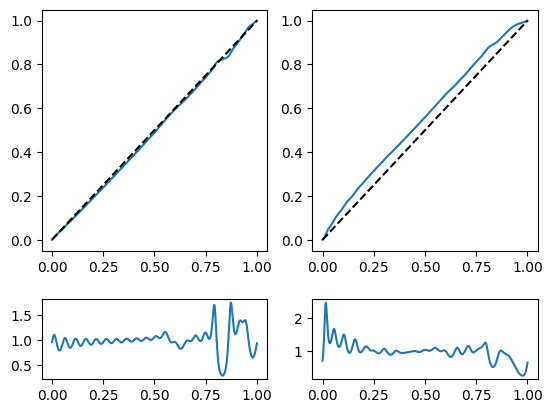

In [12]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], hspace=0.3)

# Plot gamma and its derivative for good
ax_top = fig.add_subplot(gs[0, 0])     
ax_bottom = fig.add_subplot(gs[1, 0]) 
g = output_good[0]
coordinates = (g.x, )
gam_dev = torch.gradient(g.fx.squeeze(), spacing=coordinates)[0].abs()
ax_top.plot(q_grid_scaled, g.fx.squeeze())
ax_top.plot(q_grid_scaled, q_grid_scaled, ls="--", color="k")
ax_bottom.plot(q_grid_scaled, gam_dev)

# Bad
ax_top = fig.add_subplot(gs[0, 1])    
ax_bottom = fig.add_subplot(gs[1, 1]) 
g = output_bad[0]
coordinates = (g.x, )
gam_dev = torch.gradient(g.fx.squeeze(), spacing=coordinates)[0].abs()
ax_top.plot(q_grid_scaled, g.fx.squeeze())
ax_top.plot(q_grid_scaled, q_grid_scaled, ls="--", color="k")
ax_bottom.plot(q_grid_scaled, gam_dev)

plt.show()

We can also observe that the gradients of the warping function also have reasonably smooth variations in comaprision to the dynamic programming solved warping functions. 
Finally, note that given the subtle features of the SAXS curves, it is very non-trivial to identify which two curves are more similar:
1. Between Good and the target curves, we can see that all the three peak features are common. So the shape difference primary comes from the intensity and broadness of the second peak around 
2. Bad curve is missing one feature in its SRSF resulting in a large penalty in the amplitude distance but its first two peak features match much better in terms of intensity and the broadness. 
3. We would've ideally expected the phase distance of the good curve to be much smaller than the bad curve. But due to the small difference in the shape of the second peak in the SAXS curve, the phase distance is compensating for that. Thus numericaly, both the good and bad curve have very similar phase distance. 